# Cavity Scan Finesse3 Validation

The transmitted field from a two missor resonator is given by equation 2.5 in [1],

\begin{align}
a_t = a_i \frac{-t_1t_2\exp(-ikL)}{1-r_1r_2\exp(-2ikL)}
\end{align}

As we scan a cavity we vary the parameter $L$ which corresponds to the resonator lenght. This returns the cavity scan we are used to, see below.

[1] Bond, C., Brown, D., Freise, A. et al. Living Rev Relativ (2016) 19: 3. https://doi.org/10.1007/s41114-016-0002-8

## Test Plane Wave Impedance Matched Lossless Cavity Scan
We can use the tuning parameter in Finesse as $kL$ and this behaviour against analytics for a a number of mirror transmissitivities.

Passed impedance matched cavity test with T=0.1


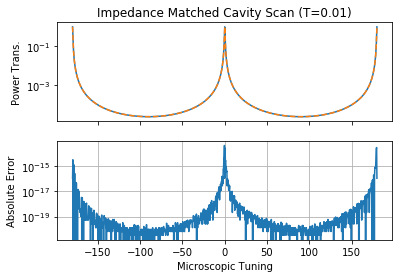

Passed impedance matched cavity test with T=0.01


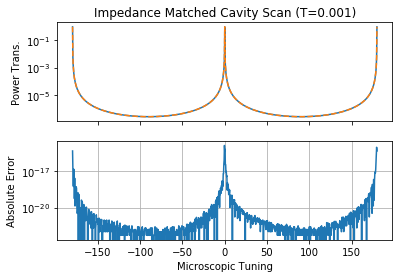

Passed impedance matched cavity test with T=0.001


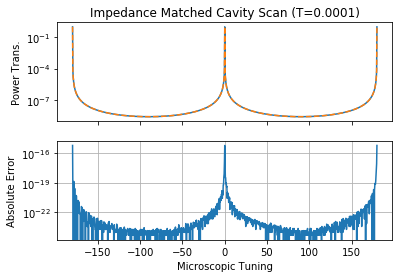

Passed impedance matched cavity test with T=0.0001


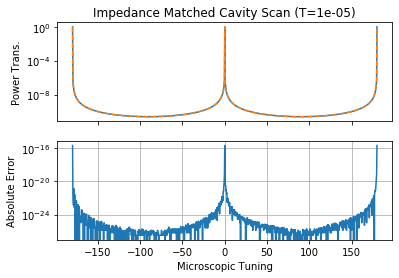

Passed impedance matched cavity test with T=1e-05


In [1]:
def test_plane_wave_cavity_scan():
    import finesse, os
    import numpy as np

    for T in np.logspace(-1,-5,num=5):
        R = 1-T

        t = np.sqrt(T)
        r = np.sqrt(R)

        npoints = 1e3

        # Analytic Model
        phi = np.linspace(-np.pi,np.pi,num=npoints+1,endpoint=True)
        at = -t*t*np.exp(1j*phi)/(1-(r*r*np.exp(2j*phi)))
        pt = np.abs(at)**2

        # Finesse Model
        kat = finesse.parse(f"""
        l laser 1 0 nLaser
        s sI 1 nLaser nIM0
        m IM {R} {T} 0 nIM0 nIM1
        s sCav 1 nIM1 nEM0
        m EM {R} {T} 0 nEM0 nEM1
        pd trans nEM1
        xaxis EM phi lin -180 180 {npoints}
        """,finesse2=True)

        out = kat.run()
        #tuning = out.x

        if 'BESTDATASERVER' in os.environ:
            print('Skipping plotting')
        else:
            %matplotlib inline
            from matplotlib import pyplot as plt
            from IPython.display import display
            fig, ax = plt.subplots(nrows=2,sharex=True)
            ax[0].semilogy(out.x1,out['trans'])
            ax[0].semilogy(180*phi/np.pi,pt,'--')

            ax[1].semilogy(out.x1,np.abs(out['trans']-pt))

            plt.grid()
            ax[1].set_xlabel('Microscopic Tuning')
            ax[0].set_ylabel('Power Trans.')
            ax[1].set_ylabel('Absolute Error')
            ax[0].set_title(f'Impedance Matched Cavity Scan (T={T})')
            fig.savefig(f'Impedance_Matched_T{T:.6f}.png')
            display(fig)
            plt.close()

        try:
            assert np.all(np.isclose(pt,out['trans'],rtol=1e-13,atol=1e-13))
        except AssertionError:
            print(f'Finesse does not match analytics for impedance matched, lossless, cavity scan with T={T}')
            sys.exit(15)
        else:
            print(f'Passed impedance matched cavity test with T={T}')
test_plane_wave_cavity_scan()

# Test Mode Behaviour For a Hemispherical Cavity

We know the round trip gouy phase for a cavity is given by eq 9.64 in [1]. 
$$
\psi = 2\arccos\left(\text{sign}(B)\sqrt{\frac{A+D+2}{4}}\right)
$$
Where $A, B, D$ are the ABCD matrix elements.

Cavity ABCD Matrix
[[-0.875   0.0375]
 [-6.25   -0.875 ]]
Cavity g factor:
0.0625
Cavity round trip gouy phase:
151.04497562814015


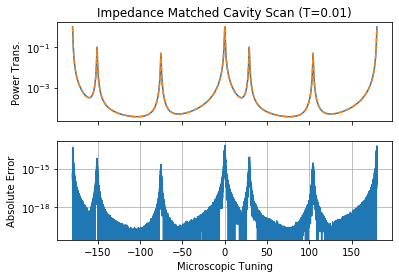

Passed impedance matched cavity test with higher order modes, T=0.01 and Gouy=151.0deg
Cavity ABCD Matrix
[[-0.5   0.15]
 [-5.   -0.5 ]]
Cavity g factor:
0.25
Cavity round trip gouy phase:
119.99999999999999


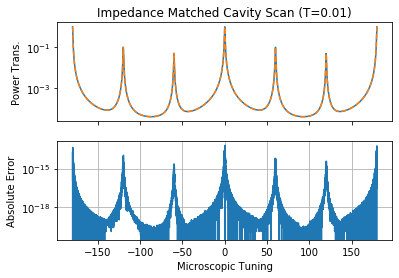

Passed impedance matched cavity test with higher order modes, T=0.01 and Gouy=120.0deg
Cavity ABCD Matrix
[[ 0.4   0.42]
 [-2.    0.4 ]]
Cavity g factor:
0.7
Cavity round trip gouy phase:
66.42182152179817


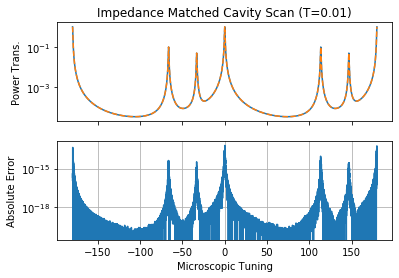

Passed impedance matched cavity test with higher order modes, T=0.01 and Gouy=66.4deg
Cavity ABCD Matrix
[[ 0.8         0.54      ]
 [-0.66666667  0.8       ]]
Cavity g factor:
0.9
Cavity round trip gouy phase:
36.869897645844034


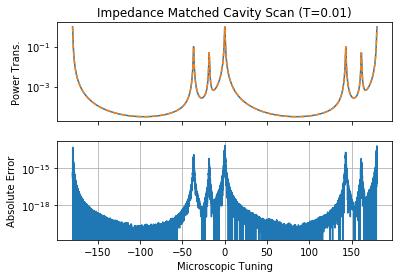

Passed impedance matched cavity test with higher order modes, T=0.01 and Gouy=36.9deg
Cavity ABCD Matrix
[[ 0.94   0.582]
 [-0.2    0.94 ]]
Cavity g factor:
0.97
Cavity round trip gouy phase:
19.94844358880269


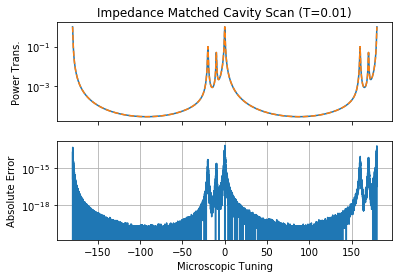

Passed impedance matched cavity test with higher order modes, T=0.01 and Gouy=19.9deg


In [3]:
def test_hemispherical_cavity_scan():
    """Proxy function to scope variables"""
    
    import finesse, os
    import numpy as np

    def mirror_refl(Rc):
        return np.matrix([[1.0,0.0],[-2.0/float(Rc),1.0]])

    def space(L):
        return np.matrix([[1.0, L],[0.0,1.0]])  
    
    def get_trans_field(n,m,phi,t,r,gouy_rt):
        """
        Return the transmitted field.
        n: HG n index
        m: HG m index 
        phi: Phase gain on a single pass though the cavity (-ikL where L = lenght of cavity)
        r: Amplitude reflectivity of mirrors
        t: Amlitute transmissivity of the mirrors
        gouy_rt: round trip (two pass) gouy phase
        """
        # We do a bit of a hack here because finesse sets the cavity lenght for the 00 mode 
        # to be the resonance condition for the 00, so whilst the gouy phase is normally
        # (n+m+1) here we set it to (n+m) to account for this
        # Also here we are scanning the single lenght of the cavity phi=-ikL
        # and the light sees this lenght twice per round trip, so
        # we need to divide the round trip cavity gouy phase by two.
        phase = phi+(0.5*n*gouy_rt)+(0.5*m*gouy_rt)
        return -t*t*np.exp(1j*phase)/(1-(r*r*np.exp(2j*phase)))
    
    
    def get_gouy_rt(Rc,L):
        """Another proxy to scope variables"""
        abcd_RT = np.matmul(space(L),
                    np.matmul(mirror_refl(Rc),
                              np.matmul(space(L),
                                        mirror_refl(np.infty))))
        
        print('Cavity ABCD Matrix')
        print(abcd_RT)
        A = abcd_RT[0,0]
        B = abcd_RT[0,1]
        C = abcd_RT[1,0]
        D = abcd_RT[1,1]
        g12 =(A+D+2)/4
        print('Cavity g factor:')
        print(g12)
        gouy_RT = 2*np.arccos(np.sign(B)*np.sqrt(g12))
        print('Cavity round trip gouy phase:')
        print(180*gouy_RT/np.pi)
        return gouy_RT
    
    def do_test(Rc):
        T = 0.01
        R = 1-T

        L = 0.3 #[m]
        #Rc = 1

        P00 = 1
        P10 = 0.05
        P02 = 0.1
        npoints = 1e4

        gouy_RT = get_gouy_rt(Rc,L)
        
        # Analytic Model
        phi = np.linspace(-np.pi,np.pi,num=npoints+1,endpoint=True)
        at00 = np.sqrt(P00)*get_trans_field(0,0,phi,np.sqrt(T),np.sqrt(R),gouy_RT)
        at10 = np.sqrt(P10)*get_trans_field(1,0,phi,np.sqrt(T),np.sqrt(R),gouy_RT)
        at02 = np.sqrt(P02)*get_trans_field(0,2,phi,np.sqrt(T),np.sqrt(R),gouy_RT)
        pt = np.abs(at00)**2 + np.abs(at02)**2 + np.abs(at10)**2

        # Finesse Model
        kat = finesse.parse(f"""
        l laser 1 0 nLaser
        tem laser 1 0 0.05 0
        tem laser 0 2 0.1 0
        s sI 1 nLaser nIM0
        m IM {R} {T} 0 nIM0 nIM1
        s sCav {L} nIM1 nEM0
        m EM {R} {T} 0 nEM0 nEM1
        attr EM Rc {Rc}
        pd trans nEM1
        cav c1 IM nIM1 EM nEM0
        xaxis EM phi lin -180 180 {npoints}
        maxtem 3
        """,finesse2=True)

        out = kat.run()

        if 'BESTDATASERVER' in os.environ:
            print('Skipping plotting')
        else:
            %matplotlib inline
            from matplotlib import pyplot as plt
            from IPython.display import display

            fig, ax = plt.subplots(nrows=2,sharex=True)
            ax[0].semilogy(out.x1,out['trans'])
            ax[0].semilogy(180*phi/np.pi,pt,'--')

            ax[1].semilogy(out.x1,np.abs(out['trans']-pt))

            plt.grid()
            ax[1].set_xlabel('Microscopic Tuning')
            ax[0].set_ylabel('Power Trans.')
            ax[1].set_ylabel('Absolute Error')
            ax[0].set_title(f'Impedance Matched Cavity Scan (T={T})')
            display(fig)
            fig.savefig(f'HOM_Matched_Gouy{180*gouy_RT/np.pi:.1f}.png')
            plt.close()
        
        try:
            assert np.all(np.isclose(pt,out['trans'],rtol=1e-13,atol=1e-13))
        except AssertionError:
            print(f'Finesse does not match analytics for impedance matched,'+
                  f' lossless, with higher order modescavity scan with T={T}'+
                  f' and Gouy={180*gouy_RT/np.pi:.1f}deg')
            sys.exit(15)
        else:
            print(f'Passed impedance matched cavity test with higher order modes, T={T}'
                  f' and Gouy={180*gouy_RT/np.pi:.1f}deg')
    
    for Rc in [0.32,0.4,1,3,10]:
        do_test(Rc)
test_hemispherical_cavity_scan()